In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image 
from numpy import asarray 
import matplotlib.image as mpimg
from scipy import ndimage
from skimage import filters, feature, measure, color
from skimage.segmentation import watershed

In [2]:
dir="C:\\Users\\preth\\Downloads\\train-20230125T045427Z-001\\train"


In [3]:
images=[]
for i in os.listdir(dir):
    images.append("".join([dir,"\\",i]))

By default the cv2 consider image as BGR. so, We are converting the color of image from BGR to RGB

In [4]:
def show(image):
    img=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(30,7))
    plt.imshow(img)

### Thresholding 

It is a process of changing the pixel size by using a threshold.
For example assume logistic regression, 
if we set threshold=0.5, then the output > 0.5 will be considered as class 1 and output < 0.5 as class 0. This is what we are exactly going to apply.


cv2.threshold(grayscale_Image,threshold,maximum value should be assigned to a pixel,thresholding type)

There are some methods to apply thresholding. They are,

1.cv.THRESH_BINARY

2.cv.THRESH_BINARY_INV

3.cv.THRESH_TRUNC

4.cv.THRESH_TOZERO

5.cv.THRESH_TOZERO_INV


#### 1.cv.THRESH_BINARY

Here if the pixel value is lesser than threshold, it will be set to zero else set to the maximum value

pixel value < threshold , then pixel value=0

pixel value > threshold , then pixel value=max value

####  2.cv.THRESH_BINARY_INV

pixel value < threshold , then pixel value=max value

pixel value > threshold , then pixel value=0

#### 3.cv.THRESH_TRUNC

pixel value < threshold , then pixel value=same pixel value

pixel value > threshold , then pixel value=threshold value

#### 4.cv.THRESH_TOZERO

pixel value < threshold , then pixel value=0

pixel value > threshold , then pixel value= same pixel value

#### 5.cv.THRESH_TOZERO_INV

pixel value < threshold , then pixel value=same pixel value

pixel value > threshold , then pixel value= 0

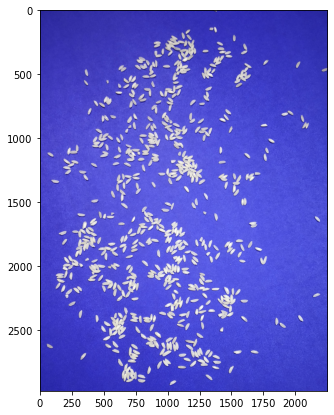

In [5]:
image=cv2.imread(images[4])
show(image)

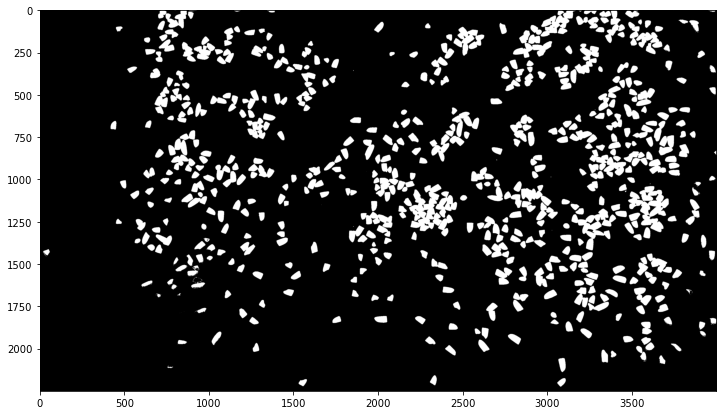

In [6]:
# Apply thresholding to the image to convert it to a binary image
img=cv2.imread(images[0])
grayscale_Image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh_img = cv2.threshold(grayscale_Image, 150, 255, cv2.THRESH_BINARY)
show(thresh_img)

### Morphological transformation

*Morphology - dealing with shapes

*It is basically used for segmentation and feature extraction

There are 2 basic morphological operations,

1.Erosion

2.Dilation

If we add pixel, then the color will be white

If we remove pixel, then the color will be black

### 1.Erosion

It basically removes pixels on th object boundaries. Since it adds pixels to the boundaries, some of the real time examples are,

*Reducing the object shape

### 2.Dilation

It adds pixels inside and outside the boundaries of the objects present in the image. Since it adds pixels to the boundaries, some of the real time examples are,

*Expanding object shapes

*It adds pixel inside the boundary or Filling gaps, holes and smoothening the boundary

#### Structuring element or Kernel

The number of pixels should added or removed from the object boundary in the image depends on the size and shape of the structuring element or kernel to process the image. The structuring element will have origin, wherever the origion and pixel meet, it will remove or add element based on the operation we are doing (erosion or dilation)


### 3.Opening

Opening is just another name of erosion followed by dilation. It is useful in removing noise, as we explained above. Here we use the function, cv.morphologyEx()

### 4.Closing

Closing is reverse of Opening, Dilation followed by Erosion. It is useful in closing small holes inside the foreground objects, or small black points on the object.

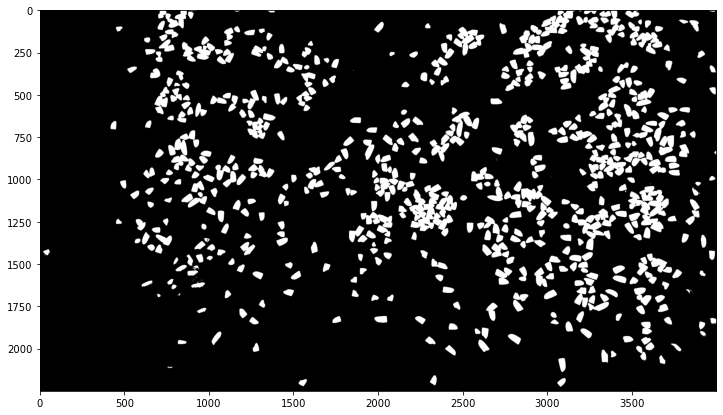

In [7]:
kernel = np.ones((3),np.uint8)

# Noise removal

clear_image = cv2.morphologyEx(thresh_img,cv2.MORPH_OPEN, kernel)

#Using show function earlier defined
show(clear_image)

To apply contour the background should be black and the object should be white.
That's why we choosed thresh binary method


### Contour 

Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity. The contours are a useful tool for shape analysis and object detection and recognition.

syntax:
 
     contours, hierarchy = cv2.findContours(image,mode,method)
     

mode : It is the contour retrieval mode (RETR_EXTERNAL,RETR_LIST,RETR_CCOMP,RETR_TREE)

method : It is the contour approximation method (CHAIN_APPROX_NONE,CHAIN_APPROX_SIMPLE,etc)


If you pass cv.CHAIN_APPROX_NONE, all the boundary points are stored. But actually do we need all the points? For eg, you found the contour of a straight line. Do you need all the points on the line to represent that line? No, we need just two end points of that line. This is what cv.CHAIN_APPROX_SIMPLE does. It removes all redundant points and compresses the contour, thereby saving memory.

In [8]:
#Applying Countours method to get the count of rice grains
contours, hierarchy = cv2.findContours(clear_image, 
                                      cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


output_contour = cv2.cvtColor(clear_image, cv2.COLOR_GRAY2BGR)

#cv2.drawContours(image, contours, -1,color,thickness of boundary)
# -1 states that we need all contours

cv2.drawContours(output_contour, contours, -1, (10,255,0), 3)
print("Number of detected contours", len(contours))

Number of detected contours 639


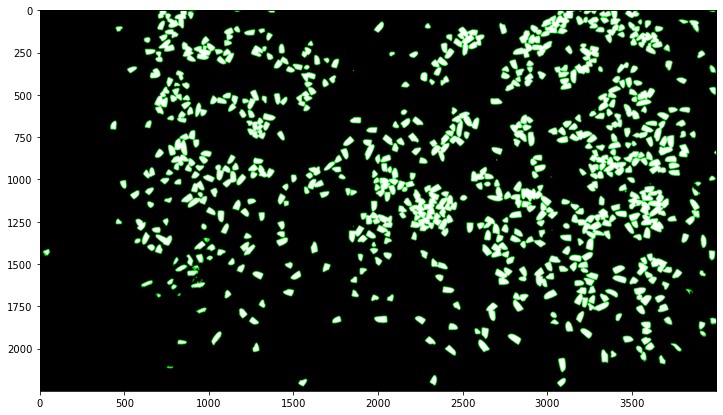

In [9]:
show(output_contour)

syntax :

         scipy.ndimage.distance_transform_edt(input, sampling=None, return_distances=True, return_indices=False, distances=None, indices=None)
         
what we are doing here is, we are computing the distance between the non zero and nearest to zero

distance = foreground - background

                    or
                    
new pixel value(distance) = x - y

where,
        x is the indivudual pixel
        
      y is the pixel with the value greater than zero
        
since, we are using binary image, ther will be only 2 pixel values 0 and 255.

In [10]:

#Applying  distance_transform_edt to computes the distance from non-zero (i.e. Foreground) points to the nearest zero (i.e. background) point.
dist_trans = ndimage.distance_transform_edt(clear_image)

#Applying peak_local_max function for getting coordinates of local peaks (maxima) in an image.
local_max = feature.peak_local_max(dist_trans, min_distance=23)


local_max_mask = np.zeros(dist_trans.shape, dtype=bool)
local_max_mask[tuple(local_max.T)] = True

#Aplying Watershed algorithm
labels = watershed(-dist_trans, measure.label(local_max_mask), mask=clear_image) # separate merged corns

Number of Rice grains are : 716


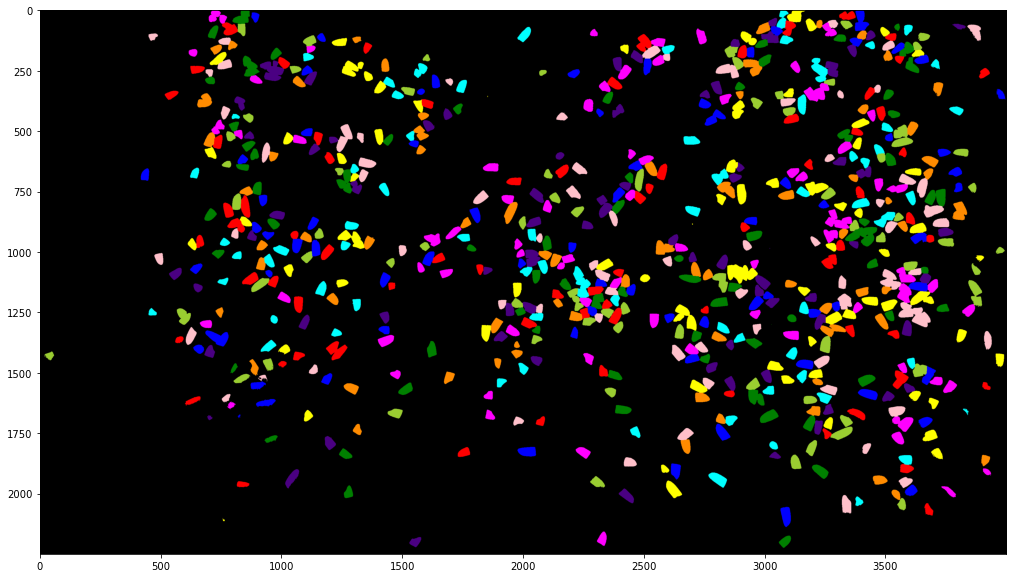

In [11]:
#label2rgb function, specifying the background label with argument bg_label=0.
plt.figure(figsize=(30,10))
plt.imshow(color.label2rgb(labels, bg_label=0))
print("Number of Rice grains are : %d" % labels.max())

In [12]:
#Creating A list name count for counting the total Broken rice grains
count = []

#Iterating through contour and filtering out the rice grains with area less than 800 and then appending to the count variable.
for x in contours:

    #Using contourArea method to get the area of rice (Contour)
    area = cv2.contourArea(x)
    if area < 1000 :
        count.append(x)

#Output of the count list.

print("Total number of broken rice present in the Image is: ",len(count))

Total number of broken rice present in the Image is:  262


In [13]:
#Creating A list name count for counting the total Broken rice grains
count = []

#Iterating through contour and filtering out the rice grains with area less than 800 and then appending to the count variable.
for x in contours:

    #Using contourArea method to get the area of rice (Contour)
    area = cv2.contourArea(x)
    count.append(area)

In [14]:
def rice_counter(image):
    img=cv2.imread(image)  #Reading image
    grayscale_Image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Converting colour to gray
    ret, thresh_img = cv2.threshold(grayscale_Image, 150, 255, cv2.THRESH_BINARY) #Converting to binary image
    kernel = np.ones((3),np.uint8)  #Defining kernel
    clear_image = cv2.morphologyEx(thresh_img,cv2.MORPH_OPEN, kernel) #Removing noice
    contours, hierarchy = cv2.findContours(clear_image,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)#Finding contour
    dist_trans = ndimage.distance_transform_edt(clear_image)
    local_max = feature.peak_local_max(dist_trans, min_distance=23)
    local_max_mask = np.zeros(dist_trans.shape, dtype=bool)
    local_max_mask[tuple(local_max.T)] = True
    labels = watershed(-dist_trans, measure.label(local_max_mask), mask=clear_image)
    return labels.max()

In [15]:
print(rice_counter(images[0]))

716


In [16]:
file_name=[]
for i in images:
    file_name.append(i.split("\\")[-1])

In [17]:
rice_count=[]
for i in range(len(images)):
    rice_count.append(rice_counter(images[i]))

In [18]:
data=pd.DataFrame({"file_name":file_name,"total_rice_grain":rice_count})

In [19]:
data

,file_name,total_rice_grain
0,broken_grain_1.jpg,716
1,broken_grain_2.jpg,539
2,broken_grain_3.jpg,1023
3,full_grain_1.jpg,318
4,full_grain_2.jpg,515
5,full_grain_3.jpg,696
6,full_grain_4.jpg,550
7,full_grain_5.jpg,647
8,full_grain_6.jpg,651
9,mixed_grains_3.jpg,703


In [20]:
data.to_csv("computer_vision_solution.csv")